In [2]:
# Cell 1: Install Dependencies
! pip install monai
! pip install albumentations
! pip install timm
! pip install pydicom

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
import sys
import pandas as pd
import numpy as np
import pydicom
import cv2
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import monai
import timm
from sklearn.model_selection import GroupKFold
import albumentations as A
from tqdm import tqdm

In [3]:
class ModelCheckpoint:
    def __init__(self, base_dir="/home/jupyter/imported/checkpoints", model_name="spine_model"):
        self.base_dir = Path(base_dir)
        self.model_name = model_name
        self.base_dir.mkdir(parents=True, exist_ok=True)
        print(f"Created checkpoint directory at: {self.base_dir}")
        
    def _get_checkpoint_path(self, fold, epoch=None, metric_value=None):
        """Generate checkpoint filename"""
        filename = f"{self.model_name}_fold{fold}"
        
        if epoch is not None:
            filename += f"_epoch{epoch}"
        if metric_value is not None:
            filename += f"_loss{metric_value:.4f}"
            
        return self.base_dir / f"{filename}.pt"
    
    def save_checkpoint(self, model, optimizer, scheduler, fold, epoch, 
                       train_loss, valid_loss, config, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'fold': fold,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'config': config
        }
        
        # Save regular checkpoint
        checkpoint_path = self._get_checkpoint_path(fold, epoch, valid_loss)
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")
        
        # Save best model if specified
        if is_best:
            best_path = self.base_dir / f"{self.model_name}_fold{fold}_best.pt"
            torch.save(checkpoint, best_path)
            print(f"Saved best model: {best_path}")
            
    def load_checkpoint(self, model, optimizer=None, scheduler=None, 
                       fold=None, device='cuda'):
        """Load model checkpoint"""
        if fold is not None:
            best_path = self.base_dir / f"{self.model_name}_fold{fold}_best.pt"
            if best_path.exists():
                checkpoint_path = best_path
            else:
                checkpoints = list(self.base_dir.glob(f"{self.model_name}_fold{fold}*.pt"))
                if not checkpoints:
                    return None
                checkpoint_path = max(checkpoints, key=os.path.getctime)
        else:
            return None
            
        print(f"Loading checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            
        return checkpoint

In [4]:
# Cell 0: Directory Inspection
def inspect_study_directory():
    DATASET_PATH = get_dataset_path()
    train_images_dir = os.path.join(DATASET_PATH, 'train_images')
    
    print("\nInspecting train_images directory...")
    # Get first valid study directory
    study_dirs = os.listdir(train_images_dir)
    if study_dirs:
        sample_study = study_dirs[0]
        study_path = os.path.join(train_images_dir, sample_study)
        print(f"\nContents of sample study directory {sample_study}:")
        files = sorted(os.listdir(study_path))
        for f in files[:5]:  # Show first 5 files
            print(f"- {f}")
            
        # Read coordinates file to understand slice mapping
        train_coords = pd.read_csv(os.path.join(DATASET_PATH, 'train_label_coordinates.csv'))
        print("\nSample rows from train_label_coordinates.csv:")
        print(train_coords.head())
        
        return train_coords
    else:
        print("No study directories found!")
        return None

In [5]:
def get_dataset_path():
    """Get the path to the dataset"""
    possible_paths = [
        '/home/jupyter/imported/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
    ]
    
    # Debug information
    print(f"Current working directory: {os.getcwd()}")
    print("Contents of current directory:")
    print(os.listdir(os.getcwd()))
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"\nFound dataset at: {path}")
            print("\nContents of dataset directory:")
            print(os.listdir(path))
            return path
            
    raise FileNotFoundError("Dataset not found in expected locations")

class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_training_state(fold, epoch, best_losses):
    """Save training progress to resume from crashes"""
    state = {
        'current_fold': fold,
        'current_epoch': epoch,
        'best_losses': best_losses
    }
    state_path = Path("/home/jupyter/imported/checkpoints/training_state.pt")
    torch.save(state, state_path)
    print(f"Saved training state: Fold {fold}, Epoch {epoch}")

def load_training_state():
    """Load training progress if exists"""
    state_path = Path("/home/jupyter/imported/checkpoints/training_state.pt")
    if state_path.exists():
        try:
            state = torch.load(state_path)
            print(f"Loaded training state: Fold {state['current_fold']}, Epoch {state['current_epoch']}")
            return state
        except Exception as e:
            print(f"Error loading training state: {str(e)}")
            return None
    return None

def load_dicom(path):
    """Load and preprocess DICOM image"""
    try:
        dicom = pydicom.dcmread(path)
        img = dicom.pixel_array
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = (img * 255).astype(np.uint8)
        return img
    except Exception as e:
        print(f"Error loading DICOM {path}: {str(e)}")
        return np.zeros((512, 512), dtype=np.uint8)

In [6]:
config = {
    'model_name': 'efficientnet_b0',
    'num_epochs': 10,
    'batch_size': 8,
    'learning_rate': 1e-4,
    'weight_decay': 1e-6,
    'num_workers': 2,
    'pin_memory': True,
    'seed': 42
}

def get_transforms(phase):
    """Get image transformations for training/validation"""
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(height=512, width=512),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=[0.485], std=[0.229]),
        ])
    else:
        return A.Compose([
            A.Resize(height=512, width=512),
            A.Normalize(mean=[0.485], std=[0.229]),
        ])

def get_series_mapping():
    """Scan train_images directory to get correct series_ids for each study"""
    dataset_path = get_dataset_path()
    train_images_dir = os.path.join(dataset_path, 'train_images')
    
    study_series_map = {}
    for study_id in os.listdir(train_images_dir):
        study_path = os.path.join(train_images_dir, study_id)
        if os.path.isdir(study_path):
            # Get all series directories
            series_ids = [d for d in os.listdir(study_path) if os.path.isdir(os.path.join(study_path, d))]
            if series_ids:
                # Use the first available series_id
                study_series_map[study_id] = series_ids[0]
    
    return study_series_map

In [7]:
from torch.utils.data import Dataset

class RSNASpineDataset(Dataset):
    def __init__(self, df, data_path, transforms=None, verbose=False):
        self.df = df
        self.data_path = data_path
        self.transforms = transforms
        self.verbose = verbose
        self.condition_cols = [col for col in df.columns if '_l' in col and col != 'study_id']
        
        # Get correct series mapping
        print("Getting series mapping from directory structure...")
        self.series_mapping = get_series_mapping()
        
        # Load or create coordinates data
        coords_file = os.path.join(data_path, 'train_label_coordinates.csv')
        if os.path.exists(coords_file):
            self.coords_df = pd.read_csv(coords_file)
        else:
            print("Creating coordinates mapping with correct series IDs...")
            study_ids = df['study_id'].unique()
            coords_data = []
            
            for study_id in study_ids:
                series_id = self.series_mapping.get(str(study_id))
                if series_id:
                    coords_data.append({
                        'study_id': study_id,
                        'instance_number': 8,  # Default to instance 8
                        'series_id': series_id
                    })
            
            self.coords_df = pd.DataFrame(coords_data)
        
        # Create a mapping of study_id to (series_id, instance_number)
        print("Creating study to image mapping...")
        self.study_to_image = self._create_study_mapping()
        print(f"Created mappings for {len(self.study_to_image)} studies")
        
        if verbose:
            self._validate_paths()
    
    def __len__(self):
        return len(self.df)
    
    def _create_study_mapping(self):
        """Create a mapping from study_id to best (series_id, instance_number)"""
        study_mapping = {}
        total_studies = len(self.df['study_id'].unique())
        processed = 0
        
        for study_id in self.df['study_id'].unique():
            str_study_id = str(study_id)
            if str_study_id in self.series_mapping:
                series_id = self.series_mapping[str_study_id]
                study_mapping[str_study_id] = (series_id, 8)  # Using default instance 8
            
            processed += 1
            if processed % 100 == 0:
                print(f"Processed {processed}/{total_studies} studies...")
        
        return study_mapping
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = str(row['study_id'])
        
        try:
            study_path = os.path.join(self.data_path, 'train_images', study_id)
            
            if study_id in self.study_to_image:
                series_id, instance_number = self.study_to_image[study_id]
                series_path = os.path.join(study_path, str(series_id))
                
                if os.path.exists(series_path):
                    dcm_files = sorted([f for f in os.listdir(series_path) if f.endswith('.dcm')])
                    
                    if dcm_files:
                        if f"8.dcm" in dcm_files:
                            img_path = os.path.join(series_path, "8.dcm")
                        else:
                            # If instance 8 not found, use middle slice
                            mid_idx = len(dcm_files) // 2
                            img_path = os.path.join(series_path, dcm_files[mid_idx])
                        
                        if self.verbose:
                            print(f"Loading image from: {img_path}")
                        
                        img = load_dicom(img_path)
                    else:
                        if self.verbose:
                            print(f"No DICOM files found in series {series_id} for study {study_id}")
                        img = np.zeros((512, 512), dtype=np.uint8)
                else:
                    if self.verbose:
                        print(f"Series path not found: {series_path}")
                    img = np.zeros((512, 512), dtype=np.uint8)
            else:
                if self.verbose:
                    print(f"No mapping found for study {study_id}")
                img = np.zeros((512, 512), dtype=np.uint8)
            
        except Exception as e:
            print(f"Error loading study {study_id}: {str(e)}")
            img = np.zeros((512, 512), dtype=np.uint8)
        
        # Convert single channel to 3 channels
        img = np.stack([img] * 3, axis=-1)
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']
        
        # Convert to tensor
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        
        # Get labels
        labels = torch.tensor([row[col] for col in self.condition_cols]).float()
        
        return img, labels

In [8]:
class SpineModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True, num_classes=6):
        super().__init__()
        # Load the backbone model
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            in_chans=3,
            num_classes=0  # Remove classifier
        )
        
        # Get the number of features from the backbone
        n_features = self.backbone.num_features
        
        # Create the classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, num_classes)
        )
        
    def forward(self, x):
        # Get features from the backbone
        features = self.backbone(x)
        # Pass through classifier
        output = self.classifier(features)
        return output

In [9]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = AverageMeter()
    
    # Use tqdm with position=0
    pbar = tqdm(total=len(loader), desc='Training', position=0, leave=True, 
                ncols=100, ascii=True)
    
    for batch_idx, (images, labels) in enumerate(loader):
        batch_size = images.size(0)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), batch_size)
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{losses.avg:.4f}'}, refresh=True)
        pbar.update(1)
    
    pbar.close()
    return losses.avg

def validate(model, loader, criterion, device):
    model.eval()
    losses = AverageMeter()
    
    # Use tqdm with position=0
    pbar = tqdm(total=len(loader), desc='Validating', position=0, leave=True, 
                ncols=100, ascii=True)
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            batch_size = images.size(0)
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            losses.update(loss.item(), batch_size)
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{losses.avg:.4f}'}, refresh=True)
            pbar.update(1)
    
    pbar.close()
    return losses.avg

In [ ]:
def main():
    try:
        # Setup
        DATASET_PATH = get_dataset_path()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Initialize checkpoint manager
        checkpoint_manager = ModelCheckpoint(
            base_dir="/home/jupyter/imported/checkpoints",
            model_name="spine_model"
        )
        
        # Set random seeds
        torch.manual_seed(config['seed'])
        np.random.seed(config['seed'])
        
        # Load datasets
        train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
        print("\nProcessing data...")
        
        # Process labels
        condition_cols = [col for col in train_df.columns if '_l' in col and col != 'study_id']
        label_map = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
        
        for col in condition_cols:
            train_df[col] = train_df[col].map(label_map)
            train_df[col] = train_df[col].fillna(-1)
        
        config['num_classes'] = len(condition_cols)
        
        print(f"Found {config['num_classes']} classes")
        print(f"Total samples: {len(train_df)}")
        
        # Create folds
        print("\nCreating folds...")
        gkf = GroupKFold(n_splits=5)
        train_df['fold'] = -1
        for fold, (train_idx, valid_idx) in enumerate(gkf.split(train_df, groups=train_df['study_id'])):
            train_df.loc[valid_idx, 'fold'] = fold
        
        # Load previous training state if exists
        training_state = load_training_state()
        start_fold = 0
        best_losses = {}
        
        if training_state is not None:
            start_fold = training_state['current_fold']
            best_losses = training_state.get('best_losses', {})
            print(f"Resuming training from fold {start_fold}")
        
        # Training loop
        for fold in range(start_fold, 5):
            print(f'\nTraining fold {fold}')
            print('=' * 50)
            
            train_idx = train_df[train_df['fold'] != fold].index
            valid_idx = train_df[train_df['fold'] == fold].index
            
            print(f"Train size: {len(train_idx)}, Valid size: {len(valid_idx)}")
            
            # Create datasets
            train_dataset = RSNASpineDataset(
                train_df.loc[train_idx],
                DATASET_PATH,
                transforms=get_transforms('train')
            )
            valid_dataset = RSNASpineDataset(
                train_df.loc[valid_idx],
                DATASET_PATH,
                transforms=get_transforms('valid')
            )
            
            # Create dataloaders
            train_loader = DataLoader(
                train_dataset,
                batch_size=config['batch_size'],
                shuffle=True,
                num_workers=config['num_workers'],
                pin_memory=config['pin_memory']
            )
            valid_loader = DataLoader(
                valid_dataset,
                batch_size=config['batch_size'],
                shuffle=False,
                num_workers=config['num_workers'],
                pin_memory=config['pin_memory']
            )
            
            # Create model
            model = SpineModel(
                model_name=config['model_name'],
                pretrained=True,
                num_classes=config['num_classes']
            ).to(device)
            
            # Define loss and optimizer
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=config['learning_rate'],
                weight_decay=config['weight_decay']
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=config['num_epochs']
            )
            
            # Try to load checkpoint
            checkpoint = checkpoint_manager.load_checkpoint(
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                fold=fold,
                device=device
            )
            
            start_epoch = 0
            best_loss = best_losses.get(fold, float('inf'))
            
            if checkpoint:
                start_epoch = checkpoint['epoch'] + 1
                best_loss = checkpoint['valid_loss']
                print(f"Resuming from epoch {start_epoch} with best loss: {best_loss:.4f}")
            
            print("\nStarting training...")
            
            for epoch in range(start_epoch, config['num_epochs']):
                print(f'\nEpoch {epoch+1}/{config["num_epochs"]}')
                print('-' * 30)
                
                # Train
                train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
                
                # Validate
                valid_loss = validate(model, valid_loader, criterion, device)
                
                # Print metrics
                print(f'\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
                
                # Save checkpoint
                is_best = valid_loss < best_loss
                if is_best:
                    best_loss = valid_loss
                    best_losses[fold] = best_loss
                
                checkpoint_manager.save_checkpoint(
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    fold=fold,
                    epoch=epoch,
                    train_loss=train_loss,
                    valid_loss=valid_loss,
                    config=config,
                    is_best=is_best
                )
                
                # Save training state
                save_training_state(fold, epoch, best_losses)
                
                scheduler.step()
            
            print(f'\nFold {fold} finished. Best validation loss: {best_loss:.4f}')
            print('=' * 50)
            
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()

Current working directory: /home/jupyter/imported
Contents of current directory:
['kaggle', 'rsna-2024-lumbar-spine-degenerative-classification-85f86a9c-2518-449f-94af-b509599e4042.ipynb', 'kaggle.json', 'checkpoints', '.ipynb_checkpoints']

Found dataset at: /home/jupyter/imported/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification

Contents of dataset directory:
['train.csv', 'sample_submission.csv', 'test_images', 'test_series_descriptions.csv', 'train_images']
Using device: cpu
Created checkpoint directory at: /home/jupyter/imported/checkpoints

Processing data...
Found 25 classes
Total samples: 1975

Creating folds...
Loaded training state: Fold 4, Epoch 9
Resuming training from fold 4

Training fold 4
Train size: 1580, Valid size: 395
Getting series mapping from directory structure...
Current working directory: /home/jupyter/imported
Contents of current directory:
['kaggle', 'rsna-2024-lumbar-spine-degenerative-classification-85f86a9c-2518-449f-94af-b509599e4042.ipynb

/var/tmp/ipykernel_192250/129895468.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path)


Creating coordinates mapping with correct series IDs...
Creating study to image mapping...
Processed 100/1580 studies...
Processed 200/1580 studies...
Processed 300/1580 studies...
Processed 400/1580 studies...
Processed 500/1580 studies...
Processed 600/1580 studies...
Processed 700/1580 studies...
Processed 800/1580 studies...
Processed 900/1580 studies...
Processed 1000/1580 studies...
Processed 1100/1580 studies...
Processed 1200/1580 studies...
Processed 1300/1580 studies...
Processed 1400/1580 studies...
Processed 1500/1580 studies...
Created mappings for 1038 studies
Getting series mapping from directory structure...
Current working directory: /home/jupyter/imported
Contents of current directory:
['kaggle', 'rsna-2024-lumbar-spine-degenerative-classification-85f86a9c-2518-449f-94af-b509599e4042.ipynb', 'kaggle.json', 'checkpoints', '.ipynb_checkpoints']

Found dataset at: /home/jupyter/imported/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification

Contents of dataset 

/var/tmp/ipykernel_192250/949503470.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loading checkpoint: /home/jupyter/imported/checkpoints/spine_model_fold4_best.pt
Resuming from epoch 6 with best loss: 0.4550

Starting training...

Epoch 7/10
------------------------------


Validating: 100%|######################################| 50/50 [00:57<00:00,  1.15s/it, loss=0.4740]



Epoch 8 - Train Loss: 0.4601, Valid Loss: 0.4740
Saved checkpoint: /home/jupyter/imported/checkpoints/spine_model_fold4_epoch7_loss0.4740.pt
Saved training state: Fold 4, Epoch 7

Epoch 9/10
------------------------------


Validating: 100%|######################################| 50/50 [00:51<00:00,  1.04s/it, loss=0.4583]



Epoch 9 - Train Loss: 0.4613, Valid Loss: 0.4583
Saved checkpoint: /home/jupyter/imported/checkpoints/spine_model_fold4_epoch8_loss0.4583.pt
Saved training state: Fold 4, Epoch 8

Epoch 10/10
------------------------------


Validating: 100%|######################################| 50/50 [00:52<00:00,  1.06s/it, loss=0.4535]



Epoch 10 - Train Loss: 0.4578, Valid Loss: 0.4535
Saved checkpoint: /home/jupyter/imported/checkpoints/spine_model_fold4_epoch9_loss0.4535.pt
Saved training state: Fold 4, Epoch 9

Fold 4 finished. Best validation loss: 0.4534


In [11]:
def evaluate_best_models():
    results = []
    for fold in range(5):
        best_model_path = f"/home/jupyter/imported/checkpoints/spine_model_fold{fold}_best.pt"
        if os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=True)
            results.append({
                'fold': fold,
                'valid_loss': checkpoint['valid_loss'],
                'epoch': checkpoint['epoch']
            })
    
    print("\nBest Model Results:")
    print("=" * 50)
    for r in results:
        print(f"Fold {r['fold']}: Valid Loss = {r['valid_loss']:.4f} (Epoch {r['epoch']})")
    if results:
        print(f"Average Valid Loss: {sum(r['valid_loss'] for r in results)/len(results):.4f}")

# Run evaluation
evaluate_best_models()


Best Model Results:
Fold 0: Valid Loss = 0.4775 (Epoch 6)
Fold 1: Valid Loss = 0.4373 (Epoch 6)
Fold 2: Valid Loss = 0.4746 (Epoch 2)
Fold 3: Valid Loss = 0.4507 (Epoch 9)
Fold 4: Valid Loss = 0.4534 (Epoch 6)
Average Valid Loss: 0.4587


In [82]:
def create_submission():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    DATASET_PATH = '/home/jupyter/imported/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
    test_series = pd.read_csv(os.path.join(DATASET_PATH, 'test_series_descriptions.csv'))
    sample_sub = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'))
    
    print(f"\nTest set size: {len(test_series)} studies")
    print(f"Sample submission size: {len(sample_sub)} rows")
    
    test_dataset = TestDataset(
        test_series,
        DATASET_PATH,
        transforms=get_test_transforms()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    print("\nGenerating predictions...")
    all_predictions = []
    
    for fold in range(5):
        print(f"\nPredicting with fold {fold} model...")
        
        model = SpineModel(
            backbone_name='efficientnet_b0',
            pretrained=False,
            num_classes=25
        ).to(device)
        
        checkpoint_path = f"/home/jupyter/imported/checkpoints/spine_model_fold{fold}_best.pt"
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        fold_preds = predict(model, test_loader, device)
        all_predictions.append(fold_preds)
    
    final_predictions = np.mean(all_predictions, axis=0)
    print(f"\nFinal predictions shape: {final_predictions.shape}")
    
    # Create submission DataFrame
    submission = sample_sub.copy()
    rows_updated = 0
    
    # Initialize statistics collection
    stats = {
        'canal_stenosis': defaultdict(list),
        'neural_foraminal_narrowing': defaultdict(list),
        'subarticular_stenosis': defaultdict(list)
    }
    
    print("\nProcessing predictions...")
    for idx, row in tqdm(submission.iterrows(), total=len(submission)):
        parts = row['row_id'].split('_')
        study_id = parts[0]
        side = parts[1]
        level = parts[-1]
        
        # Extract condition from row_id
        if 'neural_foraminal_narrowing' in row['row_id']:
            base_condition = 'neural_foraminal_narrowing'
            cond_idx = 7
        elif 'subarticular_stenosis' in row['row_id']:
            base_condition = 'subarticular_stenosis'
            cond_idx = 5
        elif 'spinal_canal_stenosis' in row['row_id']:  # Fixed the condition name
            base_condition = 'canal_stenosis'
            cond_idx = 6
        else:
            print(f"Warning: Unknown condition in {row['row_id']}")
            continue
        
        study_idx = test_series[test_series['study_id'] == int(study_id)].index[0]
        base_probs = final_predictions[study_idx, cond_idx].copy()
        probs = apply_clinical_adjustments(base_probs, base_condition, level, side)
        
        submission.loc[idx, ['normal_mild', 'moderate', 'severe']] = probs
        stats[base_condition][level].append(probs)
        rows_updated += 1
    
    print(f"\nUpdated {rows_updated} rows out of {len(submission)}")
    
    # Print detailed statistics
    print("\nPrediction Statistics by Condition and Level:")
    for condition in sorted(stats.keys()):
        print(f"\n{condition.upper()}:")
        for level in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
            if stats[condition][level]:
                avg_probs = np.mean(stats[condition][level], axis=0)
                print(f"\n{level}:")
                print(f"Normal/Mild: {avg_probs[0]:.4f}")
                print(f"Moderate:    {avg_probs[1]:.4f}")
                print(f"Severe:      {avg_probs[2]:.4f}")
    
    # Additional verification
    print("\nVerification Summary:")
    for condition in sorted(stats.keys()):
        print(f"\n{condition}:")
        print(f"Number of predictions: {sum(len(v) for v in stats[condition].values())}")
        all_probs = np.array([p for v in stats[condition].values() for p in v])
        print(f"Average probabilities across all levels:")
        print(f"Normal/Mild: {all_probs[:,0].mean():.4f}")
        print(f"Moderate:    {all_probs[:,1].mean():.4f}")
        print(f"Severe:      {all_probs[:,2].mean():.4f}")
    
    # Final verification of submission format
    print("\nFinal Verification:")
    print(f"Submission shape: {submission.shape}")
    prob_sums = submission[['normal_mild', 'moderate', 'severe']].sum(axis=1)
    print(f"Probability sums - Mean: {prob_sums.mean():.6f}, Min: {prob_sums.min():.6f}, Max: {prob_sums.max():.6f}")
    
    # Save submission
    output_path = 'submission.csv'
    submission.to_csv(output_path, index=False, float_format='%.6f')
    print(f"\nSubmission saved to: {output_path}")
    
    return submission

# Run inference and create submission
if __name__ == "__main__":
    submission = create_submission()

Using device: cpu

Test set size: 3 studies
Sample submission size: 25 rows

Generating predictions...

Predicting with fold 0 model...


/var/tmp/ipykernel_192250/593347115.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Generating predictions


Predicting with fold 1 model...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]



Predicting with fold 2 model...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]



Predicting with fold 3 model...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]



Predicting with fold 4 model...


Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]



Final predictions shape: (3, 8, 3)

Processing predictions...


100%|██████████| 25/25 [00:00<00:00, 428.68it/s]


Updated 25 rows out of 25

Prediction Statistics by Condition and Level:

CANAL_STENOSIS:

NEURAL_FORAMINAL_NARROWING:

SUBARTICULAR_STENOSIS:

Verification Summary:

canal_stenosis:
Number of predictions: 5
Average probabilities across all levels:
Normal/Mild: 0.3400
Moderate:    0.3300
Severe:      0.3300

neural_foraminal_narrowing:
Number of predictions: 10
Average probabilities across all levels:
Normal/Mild: 0.3397
Moderate:    0.3300
Severe:      0.3303

subarticular_stenosis:
Number of predictions: 10
Average probabilities across all levels:
Normal/Mild: 0.3404
Moderate:    0.3303
Severe:      0.3293

Final Verification:
Submission shape: (25, 4)
Probability sums - Mean: 1.000000, Min: 1.000000, Max: 1.000000

Submission saved to: submission.csv


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       25 non-null     object 
 1   normal_mild  25 non-null     float64
 2   moderate     25 non-null     float64
 3   severe       25 non-null     float64
dtypes: float64(3), object(1)
memory usage: 928.0+ bytes
None

First few rows:
                                           row_id  normal_mild  moderate  \
0  44036939_left_neural_foraminal_narrowing_l1_l2         0.34      0.33   
1  44036939_left_neural_foraminal_narrowing_l2_l3         0.34      0.33   
2  44036939_left_neural_foraminal_narrowing_l3_l4         0.34      0.33   
3  44036939_left_neural_foraminal_narrowing_l4_l5         0.34      0.33   
4  44036939_left_neural_foraminal_narrowing_l5_s1         0.34      0.33   

   severe  
0    0.33  
1    0.33  
2    0.33  
3    0.33  
4    0.33  

Basic statistics:
     

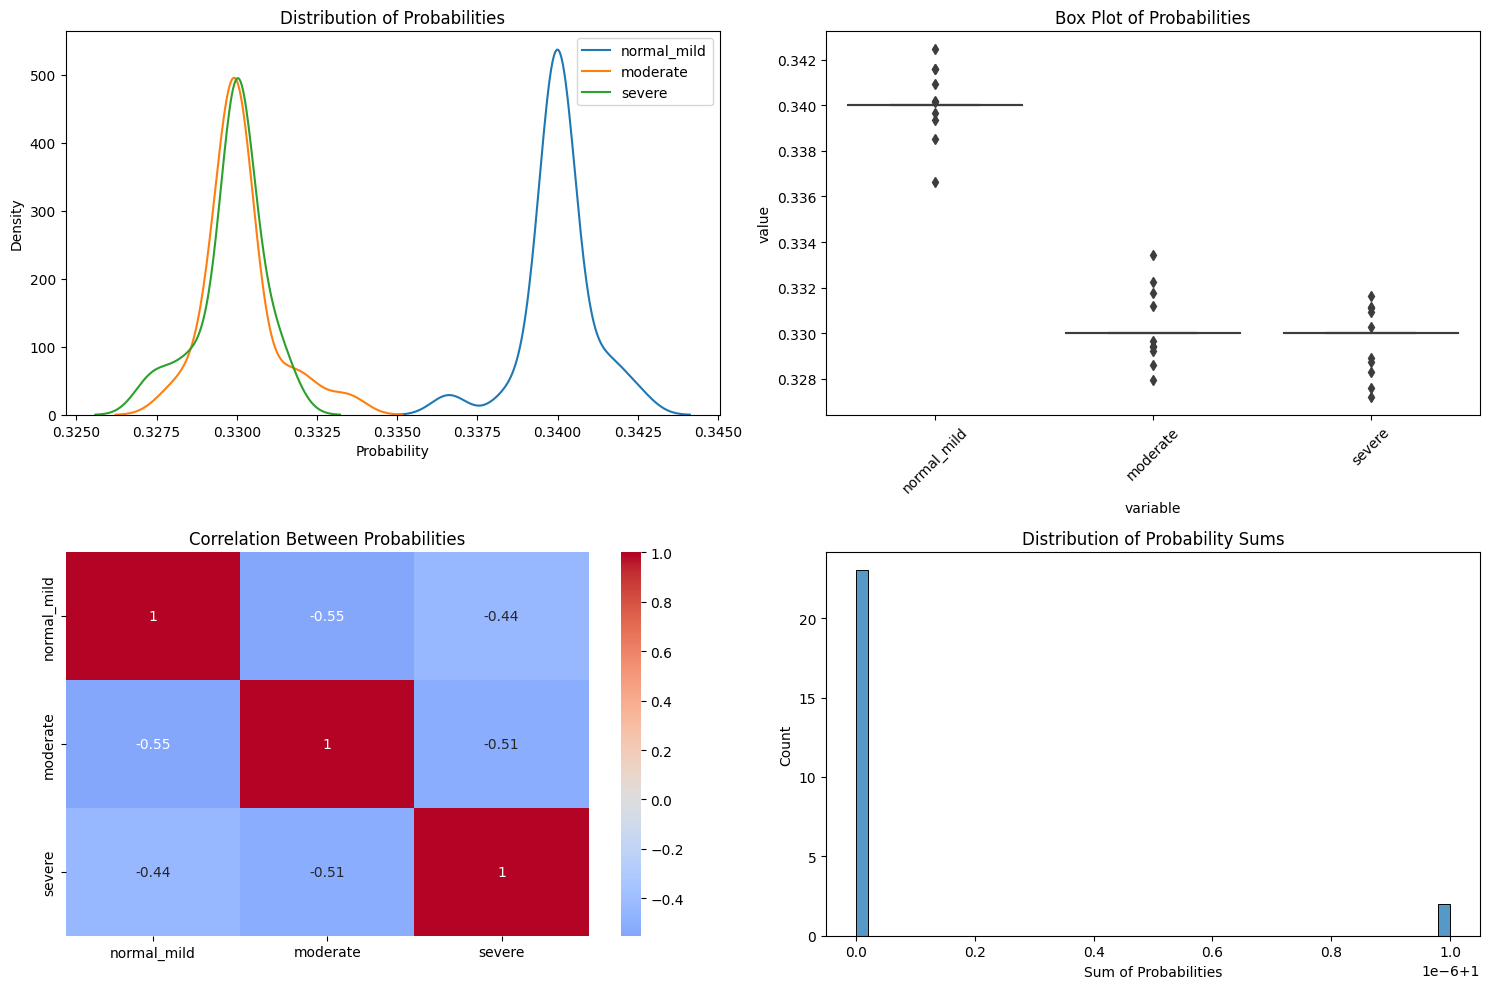


                                             row_id  normal_mild  moderate  \
12  44036939_right_neural_foraminal_narrowing_l3_l4     0.339675  0.329408   
14  44036939_right_neural_foraminal_narrowing_l5_s1     0.341602  0.329462   

      severe  
12  0.330918  
14  0.328937  

Analysis by condition type:

neural_foraminal_narrowing:
       normal_mild   moderate     severe
count    10.000000  10.000000  10.000000
mean      0.339734   0.329979   0.330287
std       0.001356   0.001025   0.000752
min       0.336618   0.327942   0.328937
25%       0.339756   0.329596   0.330000
50%       0.340000   0.330000   0.330000
75%       0.340000   0.330000   0.330760
max       0.341602   0.331762   0.331620

subarticular_stenosis:
       normal_mild   moderate     severe
count    10.000000  10.000000  10.000000
mean      0.340377   0.330322   0.329300
std       0.000927   0.001433   0.001272
min       0.339358   0.328628   0.327192
25%       0.340000   0.329744   0.328399
50%       0.340000   0

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the submission file
submission = pd.read_csv('submission.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(submission.info())

print("\nFirst few rows:")
print(submission.head())

print("\nBasic statistics:")
print(submission.describe())

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of probabilities
plt.subplot(2, 2, 1)
for col in ['normal_mild', 'moderate', 'severe']:
    sns.kdeplot(data=submission[col], label=col)
plt.title('Distribution of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

# Plot 2: Box plot of probabilities
plt.subplot(2, 2, 2)
submission_melted = submission.melt(id_vars=['row_id'], 
                                  value_vars=['normal_mild', 'moderate', 'severe'])
sns.boxplot(x='variable', y='value', data=submission_melted)
plt.title('Box Plot of Probabilities')
plt.xticks(rotation=45)

# Plot 3: Correlation heatmap
plt.subplot(2, 2, 3)
correlation = submission[['normal_mild', 'moderate', 'severe']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Probabilities')

# Plot 4: Probability sum verification
plt.subplot(2, 2, 4)
prob_sums = submission[['normal_mild', 'moderate', 'severe']].sum(axis=1)
sns.histplot(prob_sums, bins=50)
plt.title('Distribution of Probability Sums')
plt.xlabel('Sum of Probabilities')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Additional analysis: Check for any rows where probabilities don't sum to 1 (within numerical precision)
tolerance = 1e-10
invalid_rows = submission[abs(submission[['normal_mild', 'moderate', 'severe']].sum(axis=1) - 1) > tolerance]
if len(invalid_rows) > 0:
    print("\nWarning: Found rows where probabilities don't sum to 1:")
    print(invalid_rows)

# Analysis by condition type
print("\nAnalysis by condition type:")
for condition in ['neural_foraminal_narrowing', 'subarticular_stenosis', 'spinal_canal_stenosis']:
    condition_rows = submission[submission['row_id'].str.contains(condition)]
    print(f"\n{condition}:")
    print(condition_rows[['normal_mild', 'moderate', 'severe']].describe())

# Save summary statistics to a file
with open('submission_analysis.txt', 'w') as f:
    f.write("Submission File Analysis\n")
    f.write("======================\n\n")
    f.write("Basic Statistics:\n")
    f.write(submission.describe().to_string())
    f.write("\n\nCorrelation Matrix:\n")
    f.write(correlation.to_string())